In [69]:
import nengo
import nengo.spa as spa
import numpy as np
import matplotlib.pyplot as plt
import random

from nengo_learn_assoc_mem.learning_rules.fake_bcm import FakeBCM
from nengo_learn_assoc_mem.utils import gen_feed_func

%matplotlib inline

In [70]:
t_present = 0.3
n_present = 4
dt = 0.001

n_items = 6
dimensions = 32
n_neurons = 20
intercept = 0.1

In [71]:
rng = np.random.RandomState(seed=9)
vocab = spa.Vocabulary(dimensions, rng=rng)

for i in range(n_items):
    vocab.parse('X%d' % i)

items = list(range(n_items)) * n_present
random.shuffle(items)
vocab_items = ['X%d' % i for i in items]

In [72]:
class FakeAssocMem(nengo.Network):

    def __init__(self, n_neurons, dimensions, intercepts,
                 bcm_tau=0.005,
                 bcm_rate=-1e-3,
                 voja_tau=0.005,
                 voja_rate=1e-3,
                 pes_rate=1e-3,
                 seed=None,
                 ):

        super(FakeAssocMem, self).__init__()

        encoders = nengo.Default
        decoders = np.zeros((dimensions, n_neurons), dtype=float)

        self.seed = seed

        with self:
            self.input = nengo.Node(None, size_in=dimensions)
            self.output = nengo.Node(None, size_in=dimensions)
            self.correct = nengo.Node(None, size_in=dimensions)

            self.mem = nengo.Ensemble(n_neurons=n_neurons,
                                      dimensions=dimensions,
                                      intercepts=intercepts,
                                      # max_rates=nengo.dists.Uniform(150,150),
                                      encoders=encoders,
                                      seed=seed)

            learning_rule_type = nengo.Voja(post_tau=voja_tau, learning_rate=voja_rate)
            self.conn_in = nengo.Connection(self.input, self.mem,
                                            learning_rule_type=learning_rule_type)

            self.fake_bcm = FakeBCM(in_neurons=n_neurons, out_neurons=n_neurons, learning_rate=bcm_rate,
                                   start_weights=np.zeros((n_neurons, n_neurons), dtype=float))
            learn = nengo.Node(self.fake_bcm.bcm_func, size_in=n_neurons*2, size_out=n_neurons)
            nengo.Connection(self.mem.neurons, learn[:n_neurons], synapse=0.005)
            nengo.Connection(self.mem.neurons, learn[n_neurons:], synapse=0.005)
            nengo.Connection(learn, self.mem.neurons, synapse=None)

            learning_rule_type = nengo.PES(learning_rate=pes_rate)
            self.conn_out = nengo.Connection(self.mem.neurons, self.output,
                                             transform=decoders,
                                             learning_rule_type=learning_rule_type)

            self.learn_control = nengo.Node(lambda t, x: x[:-1] if x[-1] < 0.5 else x[:-1] * 0,
                                            size_in=dimensions + 1)
            nengo.Connection(self.learn_control, self.conn_out.learning_rule)
            nengo.Connection(self.output, self.learn_control[:-1], synapse=None)
            nengo.Connection(self.correct, self.learn_control[:-1], transform=-1, synapse=None)

# Basic test

In [126]:
with nengo.Network() as train_model:
    stim = nengo.Node(gen_feed_func(vocab, vocab_items, t_present))
    correct = nengo.Node(gen_feed_func(vocab, vocab_items, t_present))

    mem = FakeAssocMem(n_neurons=n_neurons, dimensions=dimensions, intercepts=[intercept] * n_neurons)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(correct, mem.correct, synapse=None)
    
    p_out = nengo.Probe(mem.output, synapse=0.01)
    p_ideal = nengo.Probe(correct, synapse=0.01)
    
    p_dec = nengo.Probe(mem.conn_out, 'weights', sample_every=t_present/2)
    p_enc = nengo.Probe(mem.mem, 'scaled_encoders', sample_every=t_present/2)

In [127]:
with nengo.Simulator(train_model) as train_sim:
    train_sim.run(n_present*n_items*t_present)
    
enc = train_sim.data[p_enc][-1]
dec = train_sim.data[p_dec][-1]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:04.                                                 


In [128]:
rec = mem.fake_bcm.weight_history[-1]
print(rec.shape)

(20, 20)


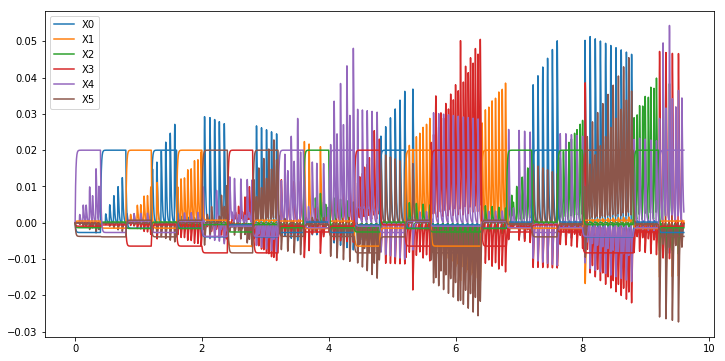

In [129]:
plt.figure(figsize=(12, 6))

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_out], vocab))

plt.gca().set_prop_cycle(None)

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_ideal], vocab)*0.02)

plt.legend(vocab.keys)

In [136]:
with nengo.Network() as test_model:
    stim = nengo.Node(gen_feed_func(vocab, vocab.keys, t_present))
    correct = nengo.Node(gen_feed_func(vocab, vocab.keys, t_present))

    recall = nengo.Node(size_in=dimensions)

    test_mem = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                              encoders=enc,
                              intercepts=[intercept] * n_neurons)
    
    nengo.Connection(test_mem.neurons, test_mem.neurons, transform=rec, synapse=0.1)
    nengo.Connection(stim, test_mem, synapse=None)
    nengo.Connection(test_mem.neurons, recall, transform=dec)
    
    p_rec = nengo.Probe(recall, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)

In [137]:
with nengo.Simulator(test_model) as test_sim:
    test_sim.run(n_items*t_present*2)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


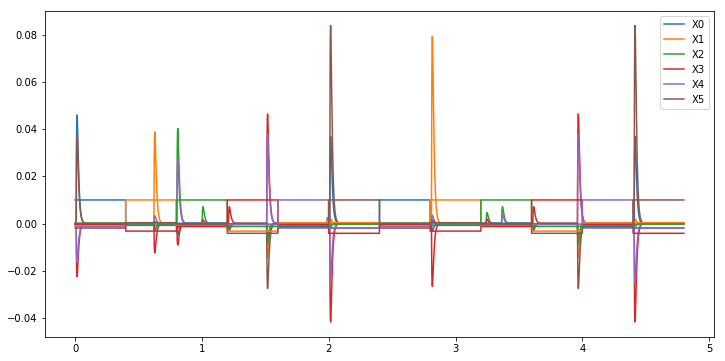

In [138]:
plt.figure(figsize=(12, 6))

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_rec], vocab))

plt.gca().set_prop_cycle(None)

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_cor], vocab)*0.01)

plt.legend(vocab.keys)

In [81]:
with nengo.Network() as test_model:
    stim = nengo.Node(gen_feed_func(vocab, vocab.keys, t_present))
    correct = nengo.Node(gen_feed_func(vocab, vocab.keys, t_present))

    recall = nengo.Node(size_in=dimensions)

    test_mem = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                              encoders=enc,
                              intercepts=[intercept] * n_neurons)
    
    nengo.Connection(stim, test_mem, synapse=None)
    nengo.Connection(test_mem.neurons, recall, transform=dec)
    
    p_rec = nengo.Probe(recall, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)

In [82]:
with nengo.Simulator(test_model) as test_sim:
    test_sim.run(n_items*t_present)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


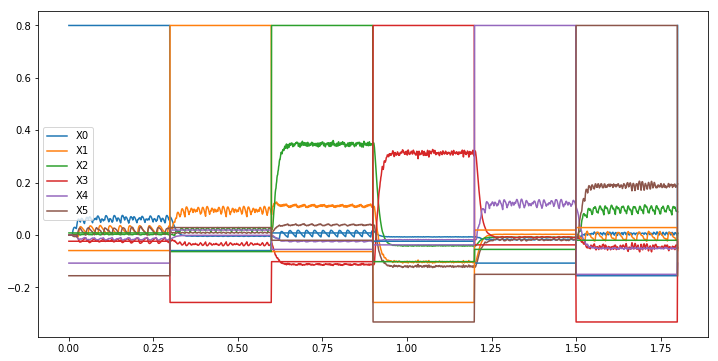

In [83]:
plt.figure(figsize=(12, 6))

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_rec], vocab))

plt.gca().set_prop_cycle(None)

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_cor], vocab)*0.8)

plt.legend(vocab.keys)

# More negative

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:03.                                                 
(20, 20)


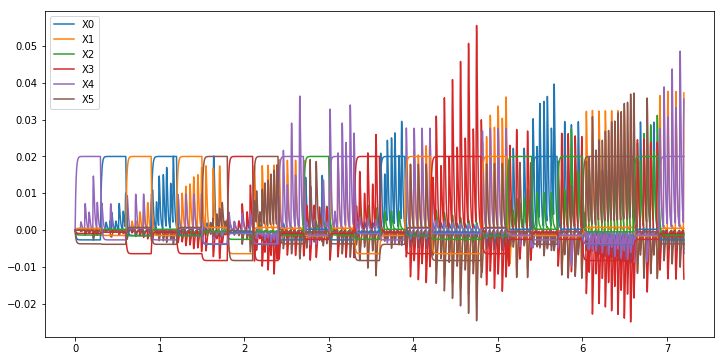

In [91]:
with nengo.Network() as train_model:
    stim = nengo.Node(gen_feed_func(vocab, vocab_items, t_present))
    correct = nengo.Node(gen_feed_func(vocab, vocab_items, t_present))

    mem = FakeAssocMem(n_neurons=n_neurons, dimensions=dimensions, intercepts=[intercept] * n_neurons, bcm_rate=-5e-4)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(correct, mem.correct, synapse=None)
    
    p_out = nengo.Probe(mem.output, synapse=0.01)
    p_ideal = nengo.Probe(correct, synapse=0.01)
    
    p_dec = nengo.Probe(mem.conn_out, 'weights', sample_every=t_present/2)
    p_enc = nengo.Probe(mem.mem, 'scaled_encoders', sample_every=t_present/2)

with nengo.Simulator(train_model) as train_sim:
    train_sim.run(n_present*n_items*t_present)
    
enc = train_sim.data[p_enc][-1]
dec = train_sim.data[p_dec][-1]

rec = mem.fake_bcm.weight_history[-1]
print(rec.shape)

plt.figure(figsize=(12, 6))

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_out], vocab))

plt.gca().set_prop_cycle(None)

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_ideal], vocab)*0.02)

plt.legend(vocab.keys)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


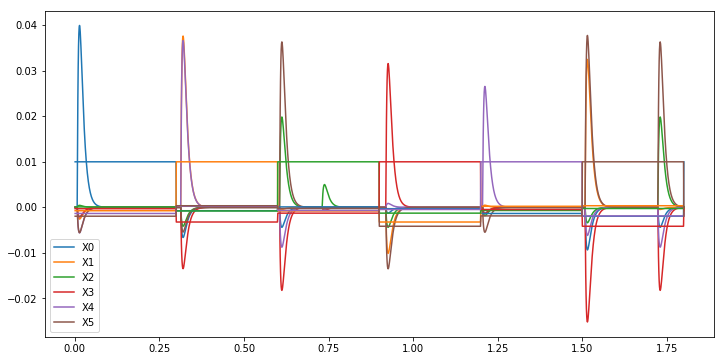

In [98]:
with nengo.Network() as test_model:
    stim = nengo.Node(gen_feed_func(vocab, vocab.keys, t_present))
    correct = nengo.Node(gen_feed_func(vocab, vocab.keys, t_present))

    recall = nengo.Node(size_in=dimensions)

    test_mem = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                              encoders=enc,
                              intercepts=[intercept] * n_neurons)
    
    nengo.Connection(test_mem.neurons, test_mem.neurons, transform=rec, synapse=0.1)
    nengo.Connection(stim, test_mem, synapse=None)
    nengo.Connection(test_mem.neurons, recall, transform=dec)
    
    p_rec = nengo.Probe(recall, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(n_items*t_present)

plt.figure(figsize=(12, 6))

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_rec], vocab))

plt.gca().set_prop_cycle(None)

plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_cor], vocab)*0.01)

plt.legend(vocab.keys)